# サポートベクターマシン(SVM)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成① （線形分離可能）

In [2]:
x0 = np.random.normal(size=50).reshape(-1, 2) - 2.
x1 = np.random.normal(size=50).reshape(-1, 2) + 2.
x_train = np.concatenate([x0, x1])
y_train = np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

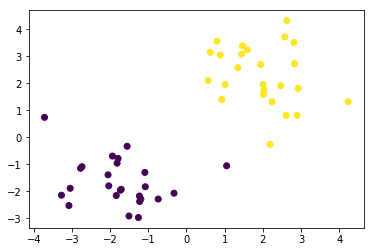

In [3]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)

## 学習

特徴空間上で線形なモデル$y(\boldsymbol{x})= \boldsymbol{w} \phi(\boldsymbol{x}) + b$を用い、その正負によって2値分類を行うことを考える。

サポートベクトターマシンではマージンの最大化を行うが、それは結局以下の最適化問題を解くことと同じである。

ただし、訓練データを$X = [\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ..., \boldsymbol{x}_{n}]^{\mathrm{T}}, \boldsymbol{t} = [t_{1}, t_{2}, ..., t_{n}]^{\mathrm{T}} (t_{i} = \{-1, +1\})$とする。

$\text{min}_{\boldsymbol{w}, b} \qquad \qquad \frac{1}{2} || \boldsymbol{w} ||^{2}$

$\text{subject to} \qquad  t_{i}(\boldsymbol{w}\phi(\boldsymbol{x}_{i}) + b) \ge 1 \quad (i=1, 2, \cdots, n)$

ラグランジュ乗数法を使うと、上の最適化問題はラグランジュ乗数$\boldsymbol{a} (\ge 0)$を用いて、以下の目的関数を最小化する問題となる。

$L(\boldsymbol{w}, b, \boldsymbol{a}) = \frac{1}{2} || \boldsymbol{w} ||^{2} - \sum_{i=1}^{n} a_{i}  t_{i}(\boldsymbol{w}\phi(\boldsymbol{x}_{i}) + b - 1) \qquad \cdots (1)$

目的関数が最小となるのは、$\boldsymbol{w}, b$に関して偏微分した値が$0$となるときなので、

$\frac{\partial L}{\partial \boldsymbol{w}} = \boldsymbol{w} - \sum_{i=1}^{n} a_{i} t_{i} \phi(\boldsymbol{x}_{i}) = \boldsymbol{0}$

$\frac{\partial L}{\partial b} = \sum_{i=1}^{n} a_{i} t_{i} = \boldsymbol{a}^{\mathrm{T}} \boldsymbol{t} = 0$

これを式(1)　に代入することで、最適化問題は結局以下の目的関数の最大化となる。

\begin{eqnarray}
\tilde{L}(\boldsymbol{a}) &=& \sum_{i=1}^{n} a_{i} - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} a_{i} a_{j} t_{i} t_{j} \phi(\boldsymbol{x}_{i})^{\mathrm{T}} \phi(\boldsymbol{x}_{j}) \\
&=& \boldsymbol{a}^{\mathrm{T}} \boldsymbol{1} - \frac{1}{2} \boldsymbol{a}^{\mathrm{T}} H \boldsymbol{a}
\end{eqnarray}

ただし、行列$H$の$i$行$j$列成分は$H_{ij} = t_{i} t_{j} \phi(\boldsymbol{x}_{i})^{\mathrm{T}} \phi(\boldsymbol{x}_{j}) = t_{i} t_{j} k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j})$である。また制約条件は、$\boldsymbol{a}^{\mathrm{T}} \boldsymbol{t} = 0 (\frac{1}{2} || \boldsymbol{a}^{\mathrm{T}} \boldsymbol{t} ||^{2} = 0)$である。

この最適化問題を最急降下法で解く。目的関数と制約条件を$\boldsymbol{a}$で微分すると、

$\frac{d \tilde{L}}{d \boldsymbol{a}} = \boldsymbol{1} - H \boldsymbol{a}$

$\frac{d}{d \boldsymbol{a}} (\frac{1}{2} || \boldsymbol{a}^{\mathrm{T}} \boldsymbol{t} ||^{2}) = (\boldsymbol{a}^{\mathrm{T}} \boldsymbol{t}) \boldsymbol{t}$

なので、$\boldsymbol{a}$を以下の二式で更新する。

$\boldsymbol{a} \leftarrow \boldsymbol{a} + \eta_{1} (\boldsymbol{1} - H \boldsymbol{a})$

$\boldsymbol{a} \leftarrow \boldsymbol{a} - \eta_{2} (\boldsymbol{a}^{\mathrm{T}} \boldsymbol{t}) \boldsymbol{t}$

In [4]:
X_train = x_train
t = np.where(y_train == 1.0, 1.0, -1.0)

n_samples = len(X_train)
# 線形カーネル
K = X_train.dot(X_train.T)

eta1 = 0.01
eta2 = 0.001
n_iter = 500

H = np.outer(t, t) * K

a = np.ones(n_samples)
for _ in range(n_iter):
    grad = 1 - H.dot(a)
    a += eta1 * grad
    a -= eta2 * a.dot(t) * t
    a = np.where(a > 0, a, 0)

## 予測

新しいデータ点$\boldsymbol{x}$に対しては、$y(\boldsymbol{x})= \boldsymbol{w} \phi(\boldsymbol{x}) + b = \sum_{i=1}^{n} a_{i} t_{i} k(\boldsymbol{x}, \boldsymbol{x}_{i}) + b$の正負によって分類する。

ここで、最適化の結果得られた$a_{i} (i = 1, 2, ...,n)$の中で$a_{i} = 0$に対応するデータ点は予測に影響を与えないので、$a_{i} > 0$に対応するデータ点（サポートベクトル）のみ保持しておく。$b$はサポートベクトルのインデックスの集合を$S$とすると、$b = \frac{1}{S} \sum_{s \in S} \left( t_{s} - \sum_{i=1}^{n} a_{i} t_{i} k(\boldsymbol{x}_{i}, \boldsymbol{x}_{s}) \right)$によって求める。

In [5]:
index = a > 1e-6
support_vectors = X_train[index]
support_vector_t = t[index]
support_vector_a = a[index]

term2 = K[index][:, index].dot(support_vector_a * support_vector_t)
b = (support_vector_t - term2).mean()

In [6]:
xx0, xx1 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
xx = np.array([xx0, xx1]).reshape(2, -1).T

X_test = xx
y_project = np.ones(len(X_test)) * b
for i in range(len(X_test)):
    for a, sv_t, sv in zip(support_vector_a, support_vector_t, support_vectors):
        y_project[i] += a * sv_t * sv.dot(X_test[i])
y_pred = np.sign(y_project)

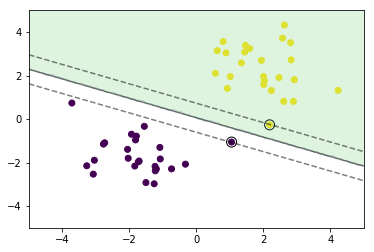

In [7]:
# 訓練データを可視化
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
# サポートベクトルを可視化
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                    s=100, facecolors='none', edgecolors='k')
# 領域を可視化
plt.contourf(xx0, xx1, y_pred.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
# マージンと決定境界を可視化
plt.contour(xx0, xx1, y_project.reshape(100, 100), colors='k',
                     levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

## 訓練データ生成② （線形分離不可能）

In [8]:
factor = .2
n_samples = 50
linspace = np.linspace(0, 2 * np.pi, n_samples // 2 + 1)[:-1]
outer_circ_x = np.cos(linspace)
outer_circ_y = np.sin(linspace)
inner_circ_x = outer_circ_x * factor
inner_circ_y = outer_circ_y * factor

X = np.vstack((np.append(outer_circ_x, inner_circ_x),
               np.append(outer_circ_y, inner_circ_y))).T
y = np.hstack([np.zeros(n_samples // 2, dtype=np.intp),
               np.ones(n_samples // 2, dtype=np.intp)])
X += np.random.normal(scale=0.15, size=X.shape)
x_train = X
y_train = y

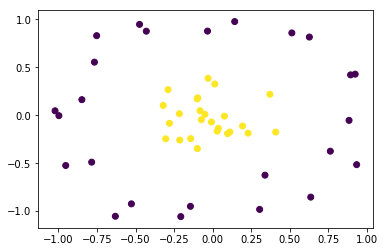

In [9]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)

## 学習

元のデータ空間では線形分離は出来ないが、特徴空間上で線形分離することを考える。

今回はカーネルとしてRBFカーネル（ガウシアンカーネル）を利用する。

In [10]:
def rbf(u, v):
        sigma = 0.8
        return np.exp(-0.5 * ((u - v)**2).sum() / sigma**2)
    
X_train = x_train
t = np.where(y_train == 1.0, 1.0, -1.0)

n_samples = len(X_train)
# RBFカーネル
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        K[i, j] = rbf(X_train[i], X_train[j])

eta1 = 0.01
eta2 = 0.001
n_iter = 5000

H = np.outer(t, t) * K

a = np.ones(n_samples)
for _ in range(n_iter):
    grad = 1 - H.dot(a)
    a += eta1 * grad
    a -= eta2 * a.dot(t) * t
    a = np.where(a > 0, a, 0)

## 予測

In [11]:
index = a > 1e-6
support_vectors = X_train[index]
support_vector_t = t[index]
support_vector_a = a[index]

term2 = K[index][:, index].dot(support_vector_a * support_vector_t)
b = (support_vector_t - term2).mean()

In [12]:
xx0, xx1 = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
xx = np.array([xx0, xx1]).reshape(2, -1).T

X_test = xx
y_project = np.ones(len(X_test)) * b
for i in range(len(X_test)):
    for a, sv_t, sv in zip(support_vector_a, support_vector_t, support_vectors):
        y_project[i] += a * sv_t * rbf(X_test[i], sv)
y_pred = np.sign(y_project)

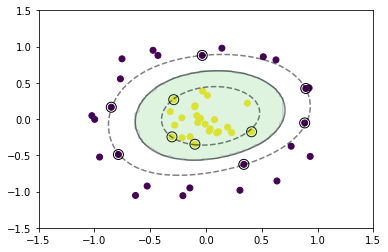

In [13]:
# 訓練データを可視化
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
# サポートベクトルを可視化
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                    s=100, facecolors='none', edgecolors='k')
# 領域を可視化
plt.contourf(xx0, xx1, y_pred.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
# マージンと決定境界を可視化
plt.contour(xx0, xx1, y_project.reshape(100, 100), colors='k',
                     levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# ソフトマージンSVM

## 訓練データ生成③（重なりあり）

In [14]:
x0 = np.random.normal(size=50).reshape(-1, 2) - 1.
x1 = np.random.normal(size=50).reshape(-1, 2) + 1.
x_train = np.concatenate([x0, x1])
y_train = np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

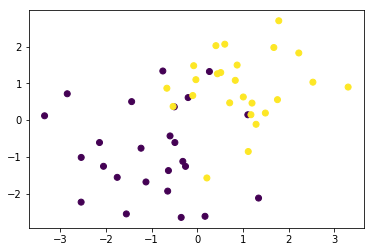

In [15]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)

## 学習

分離不可能な場合は学習できないが、データ点がマージン内部に入ることや誤分類を許容することでその問題を回避する。

スラック変数$\xi_{i} \ge 0$を導入し、マージン内部に入ったり誤分類された点に対しては、$\xi_{i} = | 1 - t_{i} y(\boldsymbol{x}_{i}) |$とし、これらを許容する代わりに対して、ペナルティを与えるように、最適化問題を以下のように修正する。

$\text{min}_{\boldsymbol{w}, b} \qquad \qquad \frac{1}{2} || \boldsymbol{w} ||^{2} + C \sum_{i=1}^{n} \xi_{i}$

$\text{subject to} \qquad  t_{i}(\boldsymbol{w}\phi(\boldsymbol{x}_{i}) + b) \ge 1 - \xi_{i} \quad (i=1, 2, \cdots, n)$

ただし、パラメータ$C$はマージンの大きさと誤差の許容度のトレードオフを決めるパラメータである。この最適化問題をラグランジュ乗数法などを用いると、結局最大化する目的関数はハードマージンSVMと同じとなる。

$\tilde{L}(\boldsymbol{a}) = \sum_{i=1}^{n} a_{i} - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} a_{i} a_{j} t_{i} t_{j} \phi(\boldsymbol{x}_{i})^{\mathrm{T}} \phi(\boldsymbol{x}_{j})$

ただし、制約条件が$a_{i} \ge 0$の代わりに$0 \le a_{i} \le C (i = 1, 2, ..., n)$となる。（ハードマージンSVMと同じ$\sum_{i=1}^{n} a_{i} t_{i} = 0$も制約条件）

In [16]:
X_train = x_train
t = np.where(y_train == 1.0, 1.0, -1.0)

n_samples = len(X_train)
# 線形カーネル
K = X_train.dot(X_train.T)

C = 1
eta1 = 0.01
eta2 = 0.001
n_iter = 1000

H = np.outer(t, t) * K

a = np.ones(n_samples)
for _ in range(n_iter):
    grad = 1 - H.dot(a)
    a += eta1 * grad
    a -= eta2 * a.dot(t) * t
    a = np.clip(a, 0, C)

## 予測

In [17]:
index = a > 1e-8
support_vectors = X_train[index]
support_vector_t = t[index]
support_vector_a = a[index]

term2 = K[index][:, index].dot(support_vector_a * support_vector_t)
b = (support_vector_t - term2).mean()

In [18]:
xx0, xx1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
xx = np.array([xx0, xx1]).reshape(2, -1).T

X_test = xx
y_project = np.ones(len(X_test)) * b
for i in range(len(X_test)):
    for a, sv_t, sv in zip(support_vector_a, support_vector_t, support_vectors):
        y_project[i] += a * sv_t * sv.dot(X_test[i])
y_pred = np.sign(y_project)

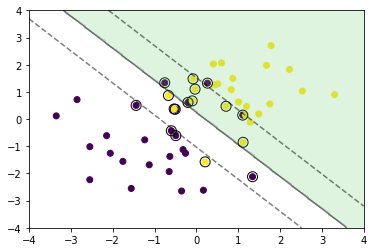

In [19]:
# 訓練データを可視化
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
# サポートベクトルを可視化
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                    s=100, facecolors='none', edgecolors='k')
# 領域を可視化
plt.contourf(xx0, xx1, y_pred.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
# マージンと決定境界を可視化
plt.contour(xx0, xx1, y_project.reshape(100, 100), colors='k',
                     levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])